# Detalles del Alumno
- Nombre: Diego Vega Camacho
- Matrícula: A01704492
- Link al repositorio de github: https://github.com/dvegaa20/Multi-Agent-Systems/tree/main/Actividad-Integradora 

# Descripción del problema
¡Felicidades! Eres el orgulloso propietario de 5 robots nuevos y un almacén lleno de cajas. El dueño anterior del almacén lo dejó en completo desorden, por lo que depende de tus robots organizar las cajas en algo parecido al orden y convertirlo en un negocio exitoso.

Cada robot está equipado con ruedas omnidireccionales y, por lo tanto, puede conducir en las cuatro direcciones. Pueden recoger cajas en celdas de cuadrícula adyacentes con sus manipuladores, luego llevarlas a otra ubicación e incluso construir pilas de hasta cinco cajas. Todos los robots están equipados con la tecnología de sensores más nueva que les permite recibir datos de sensores de las cuatro celdas adyacentes. Por tanto, es fácil distinguir si un campo está libre, es una pared, contiene una pila de cajas (y cuantas cajas hay en la pila) o está ocupado por otro robot. Los robots también tienen sensores de presión equipados que les indican si llevan una caja en ese
momento.

Lamentablemente, tu presupuesto resultó insuficiente para adquirir un software de gestión de agentes múltiples de última generación. Pero eso no debería ser un gran problema ... ¿verdad? Tu tarea es enseñar a sus robots cómo ordenar su almacén. La organización de los agentes depende de ti, siempre que todas las cajas terminen en pilas ordenadas de cinco.

# Puntos a considerar
- La semilla para generación de números aleatorios será 67890.
- El almacén es 20x20 celdas.
- Al inicio de la simulación, tu solución deberá colocar 200 cajas repartidas en grupos de 1 a 3 cajas en posiciones aleatorias.
- Todos los robots empiezan en posiciones aleatorias vacías. Y, sólo puede haber un robot por celda.
- La simulación termina cuando todas las cajas se encuentra apiladas en pilas de exactamente 5 cajas.

# ¿Que debes entregar?
Un cuaderno de Jupyter Notebook conteniendo un reporte de la actividad. El cuaderno deberá contener:
- Código fuente documentado.
- Descripción detallada de la estrategia y los mecanismos utilizados en tu solución.
- Una visualización que permita ver los diferentes pasos de la simulación.
- El número de pasos necesarios para terminar la simulación.
- ¿Existe una forma de reducir el número de pasos utilizados? Si es así, ¿cuál es la estrategia que se tendría en implementar?

### Realiza la siguiente simulación:
- Inicializa las posiciones iniciales de las K cajas. Todas las cajas están a nivel de piso, es decir, no hay pilas de cajas.
- Todos los agentes empiezan en posición aleatorias vacías.
- Se ejecuta el tiempo máximo establecido.
### Deberás recopilar la siguiente información durante la ejecución:
- Tiempo necesario hasta que todas las cajas están en pilas de máximo 5 cajas.
- Número de movimientos realizados por todos los robots.
- Analiza si existe una estrategia que podría disminuir el tiempo dedicado, así como la cantidad de movimientos realizados. ¿Cómo sería? Descríbela.

# Criterios de evaluación
Los criterios que se utilizarán para evaluar sus soluciones y seleccionar a los tres primeros ganadores son los siguientes:
- Aplicación original, innovadora y efectiva de algoritmos computacionales para resolver problemas específicos.
- El rendimiento de la implementación. El rendimiento de la implementación se medirá en función los pasos necesarios para terminar la simulación.
- La calidad de la descripción de análisis, diseño e implementación del sistema multiagente, la elegancia de su diseño e implementación.

In [158]:
# Importar las clases y funciones necesarias de Mesa
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector

# Importar las bibliotecas de visualización
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Configuraciones específicas para la animación
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128

# Configurar la semilla para la generación de números aleatorios
import random
import numpy as np
random.seed(67890)

In [159]:
# Definir una clase para representar una caja en el modelo
class Box(Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.type = 0  # Tipo de agente, en este caso, caja

In [160]:
class CleanerRobot(Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        # Propiedades del robot
        self.robot_type = 1  # Tipo de agente, en este caso, robot limpiador

        self.is_carrying_box = False  # Indica si el robot está llevando una caja
        self.carried_box_id = None  # ID único de la caja que lleva el robot
        
        self.has_tower = False  # Indica si el robot tiene una torre
        self.is_searching_for_tower = False  # Indica si el robot está buscando una torre
        self.target_tower_coord = None  # Coordenadas de la torre que el robot busca
        self.current_tower_coord = None  # Coordenadas de la torre que el robot actualmente tiene
        
        self.is_searching_for_box = False  # Indica si el robot está buscando una caja
        self.target_box_coord = None  # Coordenadas de la caja que el robot busca

    # Función para encontrar la caja más cercana
    def find_nearest_box(self):
        distances = []
        for (contents, (x, y)) in self.model.grid.coord_iter():
            if any(isinstance(c, Box) for c in contents):
                distance = self.calculate_distance(self.pos, (x, y))
                distances.append((distance, (x, y)))
        
        filtered_distances = []
        for distance in distances:
            if distance[1] in self.model.towers:
                continue
            else:
                filtered_distances.append(distance)
        filtered_distances.sort(key=lambda tup: tup[0])

        if len(filtered_distances) > 0:
            return filtered_distances[0][1]
        else:
            self.move_randomly()
    
    # Función para calcular la distancia entre dos puntos
    def calculate_distance(self, pos_agent, pos_box):
        x1, y1 = pos_agent
        x2, y2 = pos_box
        return abs(x1 - x2) + abs(y1 - y2)

    # Función para moverse hacia una caja específica
    def move_to_box(self, box_pos):
        if box_pos is None:
            self.move_randomly()
            return

        x, y = self.pos
        target_x, target_y = box_pos

        if self.pos == box_pos:
            self.move_randomly()
            return

        new_x, new_y = x, y

        if abs(x - target_x) > abs(y - target_y):
            if x < target_x:
                new_x += 1
            elif x > target_x:
                new_x -= 1
        else:
            if y < target_y:
                new_y += 1
            elif y > target_y:
                new_y -= 1

        new_position_contents = self.model.grid.get_cell_list_contents((new_x, new_y))
        if any(isinstance(agent, Box) for agent in new_position_contents):
            self.move_randomly()
            return

        self.model.grid.move_agent(self, (new_x, new_y))

    # Función para moverse aleatoriamente en la cuadrícula
    def move_randomly(self):
        possible_steps = self.model.grid.get_neighborhood(self.pos, moore=False, include_center=False)
        possible_steps_list = [step for step in possible_steps if self.model.boxes[step[0]][step[1]] == 0]

        new_position = random.choice(possible_steps_list)
        self.model.grid.move_agent(self, new_position)

    # Función para buscar una torre y marcarla si tiene una caja
    def look_for_tower(self):
        neighbors = self.model.grid.get_neighbors(self.pos, moore=True, include_center=False)
        has_box = any(isinstance(neighbor, Box) for neighbor in neighbors)
        
        if has_box:
            self.mark_tower()
        else:
            if not self.is_searching_for_tower:
                nearest_tower_pos = self.find_nearest_box()
                self.move_to_box(nearest_tower_pos)
            else:
                self.move_to_box(self.tower_dest_coord)

    # Función para marcar una torre específica
    def mark_tower(self):
        possibles = self.model.grid.get_neighbors(self.pos, moore=True, include_center=False)
        positions = set(pos for possible in possibles for pos in [possible.pos] if pos not in self.model.towers)
        positions = list(positions)

        if positions:
            count = 0
            tower_pos = None
            for position in positions:
                box_count = self.model.boxes[position[0]][position[1]]
                if box_count > count:
                    count = box_count
                    tower_pos = position
                    self.tower_coord = tower_pos

            self.has_tower = True
            self.model.towers.append(tower_pos)
        else:
            if not self.is_searching_for_tower:
                nearest_tower_pos = self.find_nearest_box()
                self.move_to_box(nearest_tower_pos)
            else:
                self.move_to_box(self.tower_dest_coord)

    # Función para buscar una caja y recogerla si no tiene una
    def look_for_box(self): 
        neighbors = self.model.grid.get_neighbors(self.pos, moore=True, include_center=False)
        box_neighbor = [neighbor for neighbor in neighbors if isinstance(neighbor, Box)]

        box_coords = [box.pos for box in box_neighbor if box.pos not in self.model.towers]

        if box_coords:
            box_pos = random.choice(box_coords)
            box = self.model.grid.get_cell_list_contents([box_pos])[0]
            self.model.pick_box(box.pos)
            self.carried_box_id = box.unique_id
            self.is_carrying_box = True
        else:
            if not self.is_searching_for_box:
                nearest_box_pos = self.find_nearest_box()
                self.is_searching_for_box = True
                self.box_coord = nearest_box_pos
                self.move_to_box(nearest_box_pos)
            else:
                self.move_to_box(self.box_coord)

    # Función para verificar si la torre que tiene está llena
    def check_tower(self):
        if self.model.boxes[self.tower_coord[0]][self.tower_coord[1]] == 5:
            self.has_tower = False
            self.tower_coord = None

    # Función para moverse hacia la torre que tiene, y dejar la caja si llega a ella
    def move_to_tower(self):
        if self.tower_coord is not None:
            x1, y1 = self.pos
            x2, y2 = self.tower_coord

            if (x1 + 1 == x2 or x1 - 1 == x2) and (y1 + 1 == y2 or y1 - 1 == y2):
                self.model.drop_box(self.tower_coord, self.carried_box_id)
                self.check_tower()
                self.is_carrying_box = False
                self.has_locked_box = False
                self.is_searching_for_box = False
                self.box_coord = None
                return
            
            if (x1 + 1 == x2 or x1 - 1 == x2) and y1 == y2:
                self.model.drop_box(self.tower_coord, self.carried_box_id)
                self.check_tower()
                self.is_carrying_box = False
                self.has_locked_box = False
                self.is_searching_for_box = False
                self.box_coord = None
                return
            
            if (y1 + 1 == y2 or y1 - 1 == y2) and x1 == x2:
                self.model.drop_box(self.tower_coord, self.carried_box_id)
                self.check_tower()
                self.is_carrying_box = False
                self.has_locked_box = False
                self.is_searching_for_box = False
                self.box_coord = None
                return

            if x1 < x2:
                x1 += 1
                self.model.grid.move_agent(self, (x1, y1))
                return
            elif x1 > x2:
                x1 += -1
                self.model.grid.move_agent(self, (x1, y1))
                return
            elif y1 < y2:
                y1 += 1
                self.model.grid.move_agent(self, (x1, y1))
                return
            elif y1 > y2:
                y1 += -1
                self.model.grid.move_agent(self, (x1, y1))
                return
        else:
            return
    
    # Función principal que se ejecuta en cada paso de la simulación    
    def step(self):
        # Acciones a realizar en cada paso, dependiendo del estado del robot
        if not self.is_carrying_box and not self.has_tower:
            self.look_for_tower()
        elif not self.is_carrying_box and self.has_tower:
            self.look_for_box()
        elif self.is_carrying_box and self.has_tower:
            self.move_to_tower()

In [161]:
# Función para obtener el estado de la cuadrícula del modelo en un momento dado
def get_grid(model):
    grid = np.zeros((model.width, model.height))
    for (contents, (x, y)) in model.grid.coord_iter():
        for content in contents:
            if isinstance(content, Box):
                grid[x][y] = model.boxes[x][y]
            elif isinstance(content, CleanerRobot):
                grid[x][y] = 10  # Valor arbitrario para representar un robot en la cuadrícula
    return grid

In [162]:
class BoxRobotModel(Model):
    def __init__(self, width, height, num_agents, num_boxes):
        self.width = width
        self.height = height
        self.num_agents = num_agents
        self.num_boxes = num_boxes
        self.random.seed(67890)

        self.boxes = np.zeros((width, height))
        self.known_boxes = np.zeros((width, height))
        self.towers = []

        self.grid = MultiGrid(width, height, torus=False)
        self.schedule = RandomActivation(self)
        self.datacollector = DataCollector(model_reporters={"Grid": get_grid})

        self.steps_taken = 0

        robotId = 0
        robot_positions = []
        for _ in range(self.num_agents):
            a = CleanerRobot(robotId, self)
            self.schedule.add(a)
            pos = self.random_empty_cell()
            while self.is_box(pos):
                pos = self.random_empty_cell()
            robot_positions.append(pos)
            self.grid.place_agent(a, pos)
            robotId += 1

        boxId = 10
        for _ in range(self.num_boxes):
            b = Box(boxId, self)
            self.schedule.add(b)
            pos = self.random_box_cell(robot_positions)
            while self.init_full(pos):
                pos = self.random_box_cell(robot_positions)
            self.grid.place_agent(b, pos)
            self.boxes[pos[0]][pos[1]] += 1
            boxId += 1

    def is_box(self, pos):
        return self.boxes[pos[0]][pos[1]] > 0
    
    def init_full(self, pos):
        return self.boxes[pos[0]][pos[1]] == 3
    
    def is_tower_full(self, pos):
        return self.boxes[pos[0]][pos[1]] == 5

    def pick_box(self, pos):
        self.boxes[pos[0]][pos[1]] -= 1
        self.grid.remove_agent(self.grid.get_cell_list_contents(pos)[0])

    def drop_box(self, pos, unique_id):
        b = Box(unique_id, self)
        self.boxes[pos[0]][pos[1]] += 1
        self.grid.place_agent(b, pos)

    def random_box_cell(self, robot_pos):
        empty_cells = [(x, y) for x in range(self.width) for y in range(self.height)]
        available_cells = [cell for cell in empty_cells if cell not in robot_pos]
        if not available_cells:
            raise Exception("No empty cells available.")
        return random.choice(available_cells)

    def random_empty_cell(self):
        empty_cells = [(x, y) for x in range(self.width) for y in range(self.height) if self.grid.is_cell_empty((x, y))]
        if not empty_cells:
            raise Exception("No empty cells available.")
        return random.choice(empty_cells)
    
    def is_simulation_done(self):
        if len(self.towers) in range(40, 45):
            return True
        else:
            return False

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()
        if not self.is_simulation_done():
            self.steps_taken += 1

In [163]:
# Configuración inicial del modelo
WIDTH = 20
HEIGHT = 20
NUM_ROBOTS = 5
NUM_BOXES = 200

In [164]:
# Crear una instancia del modelo
model = BoxRobotModel(WIDTH, HEIGHT, NUM_ROBOTS, NUM_BOXES)

# Ejecutar la simulación por un número específico de pasos
for i in range(350):
    model.step()

# Obtener datos de la simulación para la visualización
data = model.datacollector.get_model_vars_dataframe()

43


/var/folders/h7/y7vjvp757q143trmdnmrnnv00000gn/T/ipykernel_71236/2435620556.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  patch = axis.imshow(data.iloc[0][0], cmap=plt.cm.binary)
/var/folders/h7/y7vjvp757q143trmdnmrnnv00000gn/T/ipykernel_71236/2435620556.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  patch.set_data(data.iloc[frame][0])


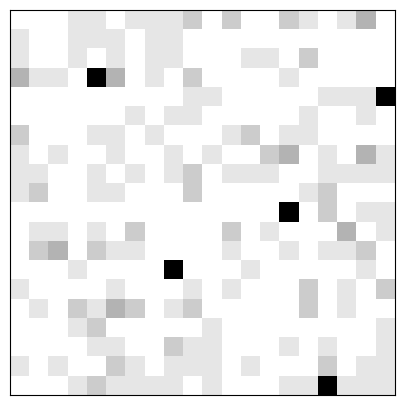

In [165]:
# Crear una visualización animada de la simulación
fig, axis = plt.subplots(figsize=(5, 5))
axis.set_xticks([])
axis.set_yticks([])
patch = axis.imshow(data.iloc[0][0], cmap=plt.cm.binary)

# Función de animación para actualizar la visualización en cada paso
def animate(frame):
    patch.set_data(data.iloc[frame][0])

# Crear la animación
steps = model.steps_taken
print(len(model.towers))
anim = animation.FuncAnimation(fig, animate, frames=350, interval=100)

In [166]:
# Imprimir el número total de pasos tomados en la simulación
print("Total Steps: ", model.steps_taken)

# Mostrar la animación
anim

/var/folders/h7/y7vjvp757q143trmdnmrnnv00000gn/T/ipykernel_71236/2435620556.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  patch.set_data(data.iloc[frame][0])


Total Steps:  124
